In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns

In [87]:
df = pd.read_excel('Online Retail.xlsx')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Online Retail Dataset Description

## Overview
This dataset contains 541,000 rows of transaction records from an online retail store, capturing details about purchases made by customers, including product information, pricing, and customer demographics.

## Column Descriptions

- **InvoiceNo**: A unique identifier for each transaction (invoice). Multiple rows with the same `InvoiceNo` represent items from the same order.
- **StockCode**: A unique product code assigned to each item sold.
- **Description**: The name or brief description of the product.
- **Quantity**: The number of units of the product purchased in the transaction.
- **InvoiceDate**: The date and time when the transaction occurred (format: `DD/MM/YYYY HH:MM`).
- **UnitPrice**: The price per unit of the product in the transaction.
- **CustomerID**: A unique identifier assigned to each customer.
- **Country**: The country where the customer is located.



In [88]:
print("Amount of rows: ", df.shape[0])
print(df.isnull().sum())

Amount of rows:  541909
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [89]:
# drolling out the rows with missing values
df = df.dropna()

In [90]:
# drop unnecessary columns
df = df.drop(['StockCode', 'Description', 'Country'], axis=1)

df.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,6,2010-12-01 08:26:00,2.55,17850.0
1,536365,6,2010-12-01 08:26:00,3.39,17850.0
2,536365,8,2010-12-01 08:26:00,2.75,17850.0
3,536365,6,2010-12-01 08:26:00,3.39,17850.0
4,536365,6,2010-12-01 08:26:00,3.39,17850.0


In [91]:
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

df.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalSpend
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34


In [92]:
# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [93]:
# Compute RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,  # Recency: Days since last purchase
    'InvoiceNo': 'nunique',  # Frequency: Number of unique purchases
    'TotalSpend': 'sum'  # Monetary Value
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Remove negative and NaN monetary values
rfm = rfm[rfm['Monetary'] > 0]

# Apply log transformation AFTER cleaning data
rfm['Monetary'] = np.log1p(rfm['Monetary'])

## Computing RFM Metrics

### Overview
RFM (Recency, Frequency, and Monetary) analysis is a customer segmentation technique that helps businesses understand purchasing behavior. It assigns customers into different groups based on their **last purchase date (Recency)**, **purchase frequency (Frequency)**, and **total spending (Monetary value)**.

### Steps:

1. **Grouping by CustomerID**  
   - Transactions are grouped by `CustomerID` to analyse each customer's purchase behavior.  

2. **Calculating RFM Metrics**  
   - **Recency**: Measures how many days have passed since a customer's last purchase. A lower value indicates an active customer.  
   - **Frequency**: Counts the number of unique purchases made by the customer. A higher frequency suggests a loyal customer.  
   - **Monetary**: Represents the total spending of a customer. Higher values indicate valuable customers.  

3. **Filtering Out Invalid Monetary Values**  
   - Customers with **negative or zero spending** are removed to maintain data accuracy. This ensures that only customers with valid purchases are considered in the segmentation process.  

4. **Applying Log Transformation**  
   - Since monetary values often have extreme variations, a **log transformation** is applied to **normalise the data** and reduce skewness. This makes the clustering process more effective.

### Why Use RFM?  
- **Recency** identifies customers who have recently interacted with the business.  
- **Frequency** helps find repeat customers and potential brand loyalists.  
- **Monetary** allows businesses to focus on high-value customers.  

### Business Applications  
- **Customer Retention**: Identify inactive customers and re-engage them with offers.  
- **Targeted Marketing**: Segment customers based on spending behavior for personalised campaigns.  
- **Loyalty Programs**: Reward frequent buyers and high-value customers.  


In [94]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


## Standardising RFM Metrics

### Why Standardisation?  
- Ensures **Recency, Frequency, and Monetary** values are on the same scale.  
- Prevents larger values (e.g., Recency in days) from dominating clustering.  
- Improves **K-Means accuracy** by giving equal importance to all features.  

### Method: StandardScaler  
- **Removes the mean** and **scales to unit variance**.  
- Transforms data so each feature has a **mean of 0** and **standard deviation of 1**.  

### Outcome  
- Normalised RFM values for **better clustering results**.  


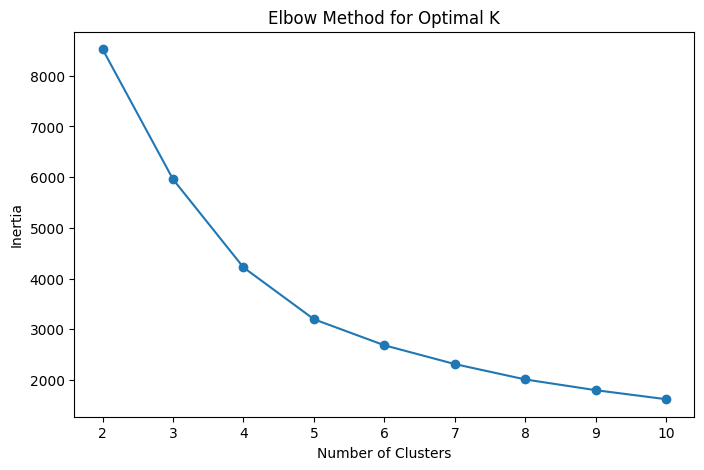

In [95]:
inertia_values = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


## Choosing the Number of Clusters with the Elbow Method

### Overview
I used the **Elbow Method** to help find the best number of clusters (**K**) for **K-Means**. This method identifies where adding more clusters **stops significantly improving the model**.

### What I Did
- Tested **K from 2 to 10**, ran K-Means, and recorded **inertia**.
- Plotted **inertia vs. number of clusters** to find the **"elbow" point**.

### Key Takeaways
- The **"elbow" is where inertia stops dropping steeply**.
- The graph **drops fast** until **K=4**, then levels off.
- **K=4 or K=5** seems optimal, balancing accuracy and efficiency.


In [101]:
from sklearn.metrics import silhouette_score

for k in [2, 3, 4, 5, 6]:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f'K={k}, Silhouette Score={score:.4f}')



K=2, Silhouette Score=0.3727
K=3, Silhouette Score=0.4248
K=4, Silhouette Score=0.4156
K=5, Silhouette Score=0.4092
K=6, Silhouette Score=0.3655


# Silhouette Score  

The **Silhouette Score** measures how well data points fit into their assigned clusters. It ranges from **-1 to 1**:
- **Closer to 1** → Well-separated clusters  
- **Around 0** → Overlapping clusters  
- **Below 0** → Poor clustering  

### **Key Findings**
- **K=3 gives the best clustering** with a **Silhouette Score of 0.4248**.  
- **K=4 and K=5** perform similarly but don’t improve separation.  
- **K=6 performs the worst**, causing overlapping clusters.  

from my research the 0.42 score is moderate but not great 


In [120]:
# Apply K-Means with the chosen number of clusters
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [121]:
# View the characteristics of each cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

print(cluster_summary)


         Recency  Frequency  Monetary
Cluster                              
0          22.95      14.95      8.32
1          47.57       2.98      6.34
2         246.77       1.70      5.58


## Cluster Characteristics

To understand the differences between customer groups, I calculated the **average Recency, Frequency, and Monetary values** for each cluster.

- **Recency**: Average days since the last purchase.  
- **Frequency**: Average number of unique purchases.  
- **Monetary**: Average total spending (log-transformed).

### Interpretation

- **Cluster 0**: Recent, frequent, and high spenders.
- **Cluster 1**: Moderate recency, lower frequency, moderate spenders.
- **Cluster 2**: Long recency, infrequent, and low spenders.




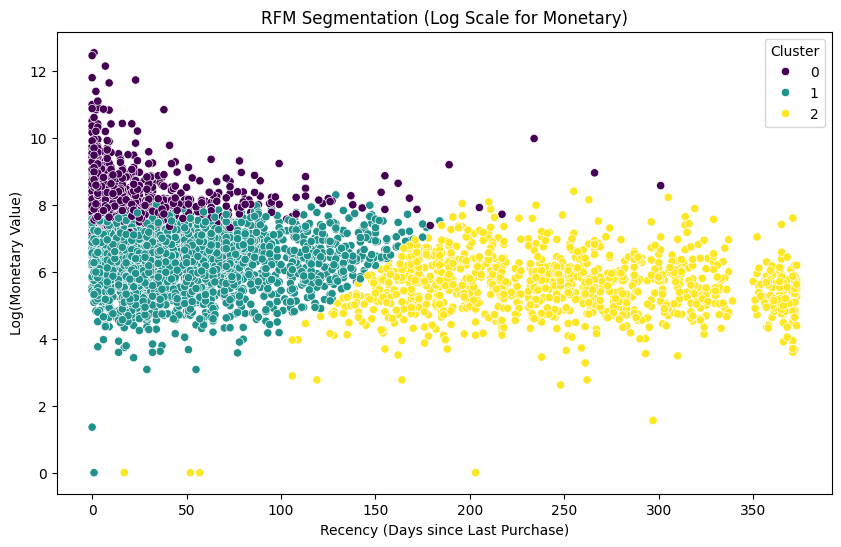

In [122]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['Cluster'], palette='viridis')
plt.xlabel('Recency (Days since Last Purchase)')
plt.ylabel('Log(Monetary Value)')
plt.title('RFM Segmentation (Log Scale for Monetary)')
plt.show()


This scatter plot visualises customer segmentation using Recency and Monetary Value.

### **Cluster Insights**
- **X-axis (Recency)**: Low values = recent buyers, high values = inactive customers.  
- **Y-axis (Log(Monetary))**: Higher values = high spenders.  

- **Cluster 0 (Purple)** → Recent, High-Spending Customers  
- **Cluster 1 (Teal)** → Moderate Recency & Spending
- **Cluster 2 (Yellow)** → Inactive Customers with Low to Moderate Spending

### **Issues with the Graph**
The graph is ok but the Clusters (mostly purple and teal) overlap too much and the yellow spreads too much

